# 16-720 HW6: Photometric Stereo

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q1**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators
**List your collaborators for all questions here**:


---

# Utils and Imports

Importing all necessary libraries.


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2xyz
import warnings
from scipy.ndimage import gaussian_filter
from matplotlib import cm
from skimage.io import imread
from scipy.sparse import kron as spkron
from scipy.sparse import eye as speye
from scipy.sparse.linalg import lsqr as splsqr
import os
import shutil


Downloading the data

In [3]:
if os.path.exists('/content/data'):
  shutil.rmtree('/content/data')

os.mkdir('/content/data')
!wget 'https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0' -O /content/data/data.zip
!unzip "/content/data/data.zip" -d "/content/"
os.system("rm /content/data/data.zip")
data_dir = '/content/data/'


--2025-04-26 21:12:27--  https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0
Resolving docs.google.com (docs.google.com)... 142.250.101.100, 142.250.101.102, 142.250.101.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.101.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download [following]
--2025-04-26 21:12:27--  https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6210854 (5.9M) [application/octet-stream]
Saving to: ‘/content/data/data.zip’

/content/data/data. 100%[===================>]   5.92M  32.

Utils Functions.

In [4]:
def integrateFrankot(zx, zy, pad = 512):

    """
    Question 1 (j)

    Implement the Frankot-Chellappa algorithm for enforcing integrability
    and normal integration

    Parameters
    ----------
    zx : numpy.ndarray
        The image of derivatives of the depth along the x image dimension

    zy : tuple
        The image of derivatives of the depth along the y image dimension

    pad : float
        The size of the full FFT used for the reconstruction

    Returns
    ----------
    z: numpy.ndarray
        The image, of the same size as the derivatives, of estimated depths
        at each point

    """

    # Raise error if the shapes of the gradients don't match
    if not zx.shape == zy.shape:
        raise ValueError('Sizes of both gradients must match!')

    # Pad the array FFT with a size we specify
    h, w = 512, 512

    # Fourier transform of gradients for projection
    Zx = np.fft.fftshift(np.fft.fft2(zx, (h, w)))
    Zy = np.fft.fftshift(np.fft.fft2(zy, (h, w)))
    j = 1j

    # Frequency grid
    [wx, wy] = np.meshgrid(np.linspace(-np.pi, np.pi, w),
                           np.linspace(-np.pi, np.pi, h))
    absFreq = wx**2 + wy**2

    # Perform the actual projection
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        z = (-j*wx*Zx-j*wy*Zy)/absFreq

    # Set (undefined) mean value of the surface depth to 0
    z[0, 0] = 0.
    z = np.fft.ifftshift(z)

    # Invert the Fourier transform for the depth
    z = np.real(np.fft.ifft2(z))
    z = z[:zx.shape[0], :zx.shape[1]]

    return z


def enforceIntegrability(N, s, sig = 3):

    """
    Question 2 (e)

    Find a transform Q that makes the normals integrable and transform them
    by it

    Parameters
    ----------
    N : numpy.ndarray
        The 3 x P matrix of (possibly) non-integrable normals

    s : tuple
        Image shape

    Returns
    -------
    Nt : numpy.ndarray
        The 3 x P matrix of transformed, integrable normals
    """

    N1 = N[0, :].reshape(s)
    N2 = N[1, :].reshape(s)
    N3 = N[2, :].reshape(s)

    N1y, N1x = np.gradient(gaussian_filter(N1, sig), edge_order = 2)
    N2y, N2x = np.gradient(gaussian_filter(N2, sig), edge_order = 2)
    N3y, N3x = np.gradient(gaussian_filter(N3, sig), edge_order = 2)

    A1 = N1*N2x-N2*N1x
    A2 = N1*N3x-N3*N1x
    A3 = N2*N3x-N3*N2x
    A4 = N2*N1y-N1*N2y
    A5 = N3*N1y-N1*N3y
    A6 = N3*N2y-N2*N3y

    A = np.hstack((A1.reshape(-1, 1),
                   A2.reshape(-1, 1),
                   A3.reshape(-1, 1),
                   A4.reshape(-1, 1),
                   A5.reshape(-1, 1),
                   A6.reshape(-1, 1)))

    AtA = A.T.dot(A)
    W, V = np.linalg.eig(AtA)
    h = V[:, np.argmin(np.abs(W))]

    delta = np.asarray([[-h[2],  h[5], 1],
                        [ h[1], -h[4], 0],
                        [-h[0],  h[3], 0]])
    Nt = np.linalg.inv(delta).dot(N)

    return Nt

def plotSurface(surface, suffix=''):

    """
    Plot the depth map as a surface

    Parameters
    ----------
    surface : numpy.ndarray
        The depth map to be plotted

    suffix: str
        suffix for save file

    Returns
    -------
        None

    """
    x, y = np.meshgrid(np.arange(surface.shape[1]),
                       np.arange(surface.shape[0]))
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, -surface, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    ax.view_init(elev = 60., azim = 75.)
    plt.savefig(f'faceCalibrated{suffix}.png')
    plt.show()

def loadData(path = "../data/"):

    """
    Question 1 (c)

    Load data from the path given. The images are stored as input_n.tif
    for n = {1...7}. The source lighting directions are stored in
    sources.mat.

    Paramters
    ---------
    path: str
        Path of the data directory

    Returns
    -------
    I : numpy.ndarray
        The 7 x P matrix of vectorized images

    L : numpy.ndarray
        The 3 x 7 matrix of lighting directions

    s: tuple
        Image shape

    """
    I = None
    L = None
    s = None

    L = np.load(path + 'sources.npy').T

    im = imread(path + 'input_1.tif')
    P = im[:, :, 0].size
    s = im[:, :, 0].shape

    I = np.zeros((7, P))
    for i in range(1, 8):
        im = imread(path + 'input_' + str(i) + '.tif')
        im = rgb2xyz(im)[:, :, 1]
        I[i-1, :] = im.reshape(-1,)

    return I, L, s

def displayAlbedosNormals(albedos, normals, s):

    """
    Question 1 (e)

    From the estimated pseudonormals, display the albedo and normal maps

    Please make sure to use the `coolwarm` colormap for the albedo image
    and the `rainbow` colormap for the normals.

    Parameters
    ----------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    -------
    albedoIm : numpy.ndarray
        Albedo image of shape s

    normalIm : numpy.ndarray
        Normals reshaped as an s x 3 image

    """
    albedoIm = None
    normalIm = None

    albedoIm = albedos.reshape(s)
    normalIm = (normals.T.reshape((s[0], s[1], 3))+1)/2

    plt.figure()
    plt.imshow(albedoIm, cmap = 'gray')

    plt.figure()
    plt.imshow(normalIm, cmap = 'rainbow')

    plt.show()

    return albedoIm, normalIm

# Q1: Calibrated photometric stereo (75 points)


### Q 1 (a): Understanding n-dot-l lighting (5 points)

---

YOUR ANSWER HERE...

In the n-dot-l lighting setup, the vector l indicates the direction of the light source, n is the surface normal at a given patch dA, and v represents the viewing direction. The angle between the surface normal and the light direction is called θ.

The dot product between n and l arises because the surface is assumed to behave according to the Lambertian reflectance model. This model states that the reflected brightness is proportional to the cosine of θ, which naturally leads to using the dot product n ⋅ l when working with unit vectors.

When θ is zero, the light hits the surface directly, and cos(θ) = 1, resulting in the maximum observed intensity. As θ increases, the effective area exposed to the light reduces, scaling by cos(θ). Thus, the projected illuminated area is dA × cos(θ).

Since we assume diffuse (Lambertian) reflection, the amount of reflected light only depends on the surface normal and light direction, not on the viewing direction. This is why the camera's viewpoint has no effect on the measured brightness.


---


### Q 1 (b): Rendering the n-dot-l lighting (10 points)

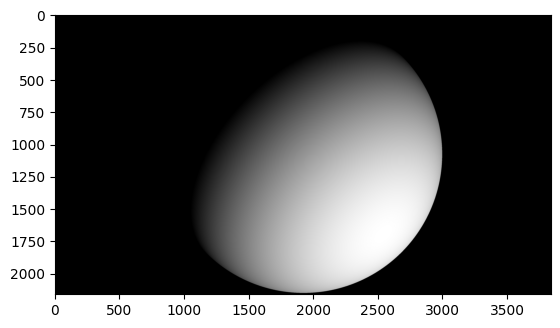

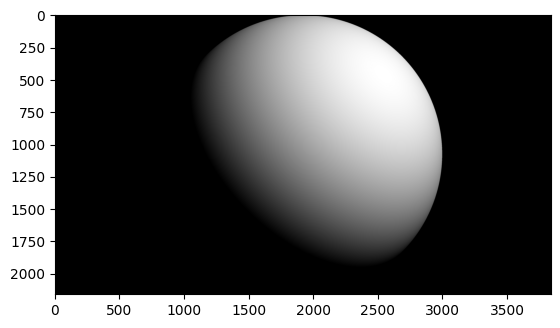

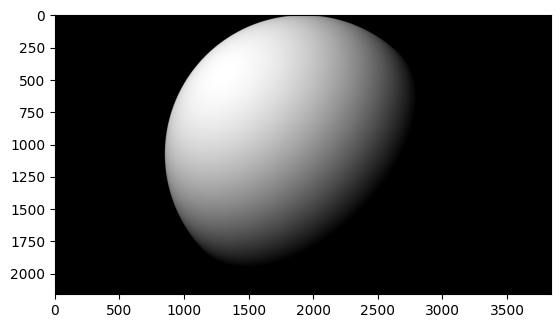

In [5]:
def renderNDotLSphere(center, rad, light, pxSize, res):

    """
    Question 1 (b)

    Render a hemispherical bowl with a given center and radius. Assume that
    the hollow end of the bowl faces in the positive z direction, and the
    camera looks towards the hollow end in the negative z direction. The
    camera's sensor axes are aligned with the x- and y-axes.

    Parameters
    ----------
    center : numpy.ndarray
        The center of the hemispherical bowl in an array of size (3,)

    rad : float
        The radius of the bowl

    light : numpy.ndarray
        The direction of incoming light

    pxSize : float
        Pixel size

    res : numpy.ndarray
        The resolution of the camera frame

    Returns
    -------
    image : numpy.ndarray
        The rendered image of the hemispherical bowl
    """

    [X, Y] = np.meshgrid(np.arange(res[0]), np.arange(res[1]))
    X = (X - res[0]/2) * pxSize*1.e-4
    Y = (Y - res[1]/2) * pxSize*1.e-4
    Z = np.sqrt(rad**2+0j-X**2-Y**2)
    X[np.real(Z) == 0] = 0
    Y[np.real(Z) == 0] = 0
    Z = np.real(Z)

    image = None
    ### YOUR CODE HERE
    mask = np.real(Z) > 0
    # Set background pixels (outside sphere) -> 0
    Z[~mask] = 0

    # normals (surface normals at each pixel)
    normals = np.stack((X, Y, Z), axis=-1)
    norm = np.linalg.norm(normals, axis=-1, keepdims=True)
    normals = normals / np.maximum(norm, 1e-8)  # Avoid divide by 0

    # n · l at each pixel
    light = light / np.linalg.norm(light)
    n_dot_l = np.clip(np.sum(normals * light, axis=-1), 0, 1)  # Only positive values

    n_dot_l[~mask] = 0  # Set background -> 0

    image = n_dot_l  # Final rendered image


    ### END YOUR CODE

    return image

# Part 1(b)
radius = 0.75 # cm
center = np.asarray([0, 0, 0]) # cm
pxSize = 7 # um
res = (3840, 2160)

light = np.asarray([1, 1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-a.png', image, cmap = 'gray')

light = np.asarray([1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-b.png', image, cmap = 'gray')

light = np.asarray([-1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-c.png', image, cmap = 'gray')

I, L, s = loadData(data_dir)

### Q 1 (c): Initials (10 points)


Singular values of I: [79.36348099 13.16260675  9.22148403  2.414729    1.61659626  1.26289066
  0.89368302]


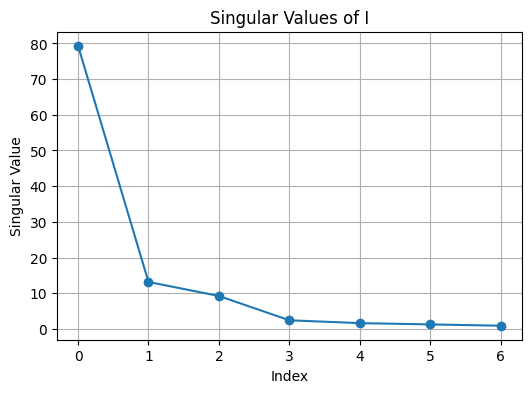

In [6]:
### YOUR CODE HERE
# Compute SVD of I
U, S, Vt = np.linalg.svd(I, full_matrices=False)

# Print the singular values
print("Singular values of I:", S)

# Optional: plot them to visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(S, marker='o')
plt.title('Singular Values of I')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()

### END YOUR CODE


---

YOUR ANSWER HERE...

I model the images using the relation I=L^T B, where B is the pseudonormal matrix (combining albedo and normal) and L is the matrix of lighting directions. Since B has only 3 rows (one for each spatial dimension), the matrix I should have rank at most 3.
To verify this, I performed a Singular Value Decomposition (SVD) of I and observed the following singular values:

Singular values of I: [79.36348099 13.16260675  9.22148403  2.414729    1.61659626  1.26289066 0.89368302]
I see that the first three singular values are large while the remaining singular values are close to zero. This confirms that I effectively has rank 3, as expected from the theoretical model.

---

### Q 1 (d) Estimating pseudonormals (20 points)

In [7]:
def estimatePseudonormalsCalibrated(I, L):

    """
    Question 1 (d)

    In calibrated photometric stereo, estimate pseudonormals from the
    light direction and image matrices

    Parameters
    ----------
    I : numpy.ndarray
        The 7 x P array of vectorized images

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

    Returns
    -------
    B : numpy.ndarray
        The 3 x P matrix of pesudonormals
    """

    B = None
    ### YOUR CODE HERE
    # I = L^T B
    # I is 7 x P (7 images, P pixels)
    # L^T is 7 x 3 (transpose of lighting directions)
    # B is 3 x P (pseudonormals at each pixel)

    # For each pixel, need to solve a least squares problem
    # solve this for all pixels simultaneously

    # In the form Ax = y:
    # A = L^T (7 x 3)
    # x = B (3 x P, but solve for each column)
    # y = I (7 x P, each column is a pixel's intensities)

    # need to solve (L^T)^T L^T B = (L^T)^T I
    # Which simplifies to L L^T B = L I
    # But it's easier to use numpy's least squares solver

    # Solve least squares problem for each pixel
    L_T = L.T  # 7 x 3
    B = np.linalg.lstsq(L_T, I, rcond=None)[0]  # 3 x P
    ### END YOUR CODE

    return B

# Part 1(e)
B = estimatePseudonormalsCalibrated(I, L)


---

YOUR ANSWER HERE...

I constructed the system Ax = y by setting A as the transpose of the lighting directions matrix (L^T), which is a 7×3 matrix where each row represents one lighting direction. For y, I used the observed intensities for each pixel, forming a 7×1 vector containing the measurements from all 7 illumination conditions for that specific pixel. This formulation directly models our image formation equation I = L^T B, where for each pixel we need to solve for its pseudonormal vector. By using numpy's least squares solver, I find the pseudonormal values that best explain the observed intensities under the given lighting directions, effectively minimizing the error ||L^T B - I||² across all pixels simultaneously.
---


### Q 1 (e) Albedos and normals (10 points)

---

YOUR ANSWER HERE...

---

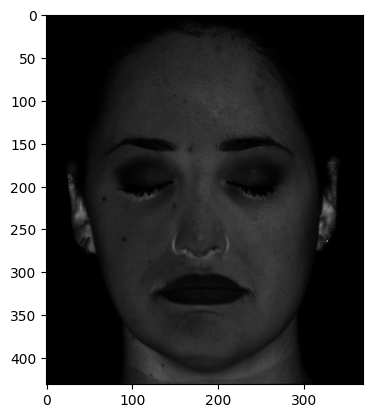

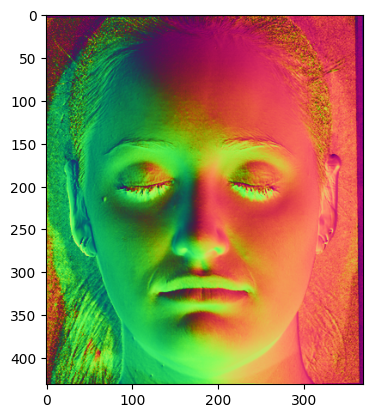

In [8]:
def estimateAlbedosNormals(B):

    '''
    Question 1 (e)

    From the estimated pseudonormals, estimate the albedos and normals

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of estimated pseudonormals

    Returns
    -------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals
    '''

    albedos = None
    normals = None

    ### YOUR CODE HERE

    # albedo: magnitude (L2 norm) of each pseudonormal vector
    albedos = np.linalg.norm(B, axis=0)

    # The normals are the normalized pseudonormals
    # (unit vectors in the same direction)
    # To avoid division by zero, handle the case where albedo = 0
    normals = np.zeros_like(B)
    non_zero_indices = albedos > 0
    normals[:, non_zero_indices] = B[:, non_zero_indices] / albedos[non_zero_indices]
    ### END YOUR CODE

    return albedos, normals


# Part 1(e)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('1f-a.png', albedoIm, cmap = 'gray')
plt.imsave('1f-b.png', normalIm, cmap = 'rainbow')


### Q 1 (f): Normals and depth (5 points)

---

YOUR ANSWER HERE...

To derive the relationship between the normal vector n = (n₁, n₂, n₃) and the partial derivatives of the depth function f(x,y), I start with a point on the surface with coordinates (x, y, f(x,y)).
The tangent vectors in the x and y directions are:

T₁ = (1, 0, ∂f/∂x)

T₂ = (0, 1, ∂f/∂y)

The surface normal is perpendicular to both tangent vectors, so I can find it by taking their cross product:

n = T₁ * T₂

n = (1, 0, ∂f/∂x) * (0, 1, ∂f/∂y)

n = [(0·∂f/∂y) - (∂f/∂x·1), (∂f/∂x·0) - (1·∂f/∂y), (1·1) - (0·0)]

n = [-∂f/∂x, -∂f/∂y, 1]

This gives us the unnormalized normal vector. When normalized, this becomes:

n = [-∂f/∂x, -∂f/∂y, 1] / √[(∂f/∂x)² + (∂f/∂y)² + 1]

Comparing with our notation n = (n₁, n₂, n₃), we have:

n₁ = -∂f/∂x / √[(∂f/∂x)² + (∂f/∂y)² + 1]

n₂ = -∂f/∂y / √[(∂f/∂x)² + (∂f/∂y)² + 1]

n₃ = 1 / √[(∂f/∂x)² + (∂f/∂y)² + 1]

Now I can solve for the partial derivatives:

n₁/n₃ = -∂f/∂x

n₂/n₃ = -∂f/∂y

Therefore:

fx = ∂f/∂x = -n₁/n₃

fy = ∂f/∂y = -n₂/n₃

---

### Q 1 (g): Understanding integrability of gradients (5 points)

---

YOUR ANSWER HERE...


First, I compute the $x$ and $y$ gradients of the given matrix $g$ using the formulas $g_x(x_i, y_j) = g(x_{i+1}, y_j) - g(x_i, y_j)$ and $g_y(x_i, y_j) = g(x_i, y_{j+1}) - g(x_i, y_j)$:

For the $x$-gradient:
\begin{align}
g_x = \begin{bmatrix}
2-1 & 3-2 & 4-3 \\
6-5 & 7-6 & 8-7 \\
10-9 & 11-10 & 12-11 \\
14-13 & 15-14 & 16-15
\end{bmatrix} = \begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}
\end{align}

For the $y$-gradient:
\begin{align}
g_y = \begin{bmatrix}
5-1 & 6-2 & 7-3 & 8-4 \\
9-5 & 10-6 & 11-7 & 12-8 \\
13-9 & 14-10 & 15-11 & 16-12
\end{bmatrix} = \begin{bmatrix}
4 & 4 & 4 & 4 \\
4 & 4 & 4 & 4 \\
4 & 4 & 4 & 4
\end{bmatrix}
\end{align}

Now I perform the two reconstruction procedures:

Procedure 1: Starting with $g(0,0) = 1$, use $g_x$ to construct the first row of $g$, then use $g_y$ to construct the rest of $g$.
\begin{align}
\text{First row:} &\quad [1, 1+1=2, 2+1=3, 3+1=4] \\
\text{Second row:} &\quad [1+4=5, 2+4=6, 3+4=7, 4+4=8] \\
\text{Third row:} &\quad [5+4=9, 6+4=10, 7+4=11, 8+4=12] \\
\text{Fourth row:} &\quad [9+4=13, 10+4=14, 11+4=15, 12+4=16]
\end{align}

Procedure 2: Starting with $g(0,0) = 1$, use $g_y$ to construct the first column of $g$, then use $g_x$ to construct the rest of $g$.
\begin{align}
\text{First column:} &\quad [1, 1+4=5, 5+4=9, 9+4=13] \\
\text{Row 1:} &\quad [1, 1+1=2, 2+1=3, 3+1=4] \\
\text{Row 2:} &\quad [5, 5+1=6, 6+1=7, 7+1=8] \\
\text{Row 3:} &\quad [9, 9+1=10, 10+1=11, 11+1=12] \\
\text{Row 4:} &\quad [13, 13+1=14, 14+1=15, 15+1=16]
\end{align}

Both procedures yield the original matrix $g$, confirming that these gradients are integrable.

To make $g_x$ and $g_y$ non-integrable, I could modify one gradient value. For example, if I change $g_x(0,0)$ from 1 to 2:
\begin{align}
\text{Modified } g_x = \begin{bmatrix}
\mathbf{2} & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}
\end{align}

Now the two reconstruction procedures would yield different results:
\begin{align}
\text{Procedure 1, first row:} &\quad [1, 1+\mathbf{2}=\mathbf{3}, 3+1=\mathbf{4}, 4+1=\mathbf{5}] \\
\text{Procedure 2, first column:} &\quad [1, 1+4=5, 5+4=9, 9+4=13]
\end{align}

These reconstructions would propagate differently throughout the matrix, making the gradients non-integrable.

The gradients estimated as in part (g) might be non-integrable in real-world scenarios due to:

Measurement noise leading to inconsistent gradient estimates

Discretization errors when computing numerical gradients

Surface discontinuities violating the assumption of surface smoothness

Approximation errors in the gradient estimation process

In photometric stereo specifically, shadows, specularities, and non-Lambertian reflectance can cause inaccurate normal/gradient estimations


The Frankot-Chellappa algorithm addresses this issue by projecting potentially non-integrable gradients onto the space of integrable gradients, ensuring a physically plausible reconstructed surface.

---

### Q 1 (h): Shape estimation (10 points)

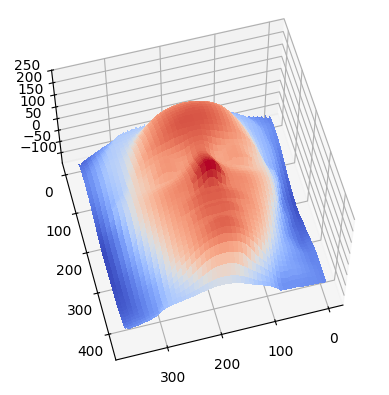

In [9]:
def estimateShape(normals, s):

    """
    Question 1 (h)

    Integrate the estimated normals to get an estimate of the depth map
    of the surface.

    Parameters
    ----------
    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    ----------
    surface: numpy.ndarray
        The image, of size s, of estimated depths at each point

    """

    surface = None

    ### YOUR CODE HERE

    # Extract the components of the normal vectors
    n1 = normals[0, :].reshape(s)
    n2 = normals[1, :].reshape(s)
    n3 = normals[2, :].reshape(s)

    # Calculate the partial derivatives using the relationship derived earlier
    # fx = -n1/n3 and fy = -n2/n3
    fx = -n1 / (n3 + 1e-10)  # Adding small epsilon to avoid division by zero
    fy = -n2 / (n3 + 1e-10)

    # Since we can't import from utils, we need to call the integrateFrankot function
    # that's already imported in your notebook. Assuming it's already available:
    surface = integrateFrankot(fx, fy)



    ### END YOUR CODE

    return surface


# Part 1(h)
surface = estimateShape(normals, s)
plotSurface(surface)




# Q2: Uncalibrated photometric stereo (50 points)

### Q 2 (a): Uncalibrated normal estimation (10 points)

---

YOUR ANSWER HERE...

To construct a factorization of $\mathbf{I} = \mathbf{L}^T \mathbf{B}$ when neither $\mathbf{L}$ nor $\mathbf{B}$ is known, I can use Singular Value Decomposition (SVD).

Given our image matrix $\mathbf{I}$ (of dimensions $m \times n$ where $m$ is the number of images and $n$ is the number of pixels), I first perform SVD:

\begin{align}
\mathbf{I} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
\end{align}

Where:
$\mathbf{U}$ is an $m \times m$ orthogonal matrix

$\mathbf{\Sigma}$ is an $m \times n$ diagonal matrix containing singular values $\sigma_1 \geq \sigma_2 \geq \ldots \geq 0$

$\mathbf{V}^T$ is an $n \times n$ orthogonal matrix


Since we know from our earlier analysis that $\mathbf{I}$ should have rank 3 (due to the 3D nature of surface normals), I create a rank-3 approximation by keeping only the top 3 singular values:

\begin{align}
\mathbf{I} \approx \hat{\mathbf{I}} = \mathbf{U} \hat{\mathbf{\Sigma}} \mathbf{V}^T
\end{align}

Where $\hat{\mathbf{\Sigma}}$ is $\mathbf{\Sigma}$ with all singular values except the top 3 set to zero.

Now I need to factorize $\hat{\mathbf{I}}$ into $\mathbf{L}^T$ and $\mathbf{B}$. One way to do this is:

\begin{align}
\hat{\mathbf{L}}^T &= \mathbf{U} \hat{\mathbf{\Sigma}}^{1/2} \\
\hat{\mathbf{B}} &= \hat{\mathbf{\Sigma}}^{1/2} \mathbf{V}^T
\end{align}

However, this decomposition isn't unique. There's a $3 \times 3$ ambiguity represented by any invertible matrix $\mathbf{A}$:

\begin{align}
\hat{\mathbf{I}} &= (\mathbf{U} \hat{\mathbf{\Sigma}}^{1/2}) \cdot (\hat{\mathbf{\Sigma}}^{1/2} \mathbf{V}^T) \\
&= (\mathbf{U} \hat{\mathbf{\Sigma}}^{1/2} \mathbf{A}) \cdot (\mathbf{A}^{-1} \hat{\mathbf{\Sigma}}^{1/2} \mathbf{V}^T) \\
&= \hat{\mathbf{L}}^T \cdot \hat{\mathbf{B}}
\end{align}

This ambiguity is known as the "generalized bas-relief ambiguity" in uncalibrated photometric stereo, which means I can recover the surface only up to a linear transformation without additional constraints.

The dimensions work correctly:

$\hat{\mathbf{L}}^T$ is $m \times 3$ (representing $m$ lighting conditions $\times$ 3 dimensions)

$\hat{\mathbf{B}}$ is $3 \times n$ (representing 3 dimensions $\times$ $n$ pixels)

Their product $\hat{\mathbf{L}}^T \cdot \hat{\mathbf{B}} = \hat{\mathbf{I}}$ is $m \times n$ (matching our original image dimensions)


This factorization satisfies our constraints: it ensures that $\hat{\mathbf{I}} = \hat{\mathbf{L}}^T \cdot \hat{\mathbf{B}}$ has rank 3, and $\hat{\mathbf{L}}$ and $\hat{\mathbf{B}}$ have the appropriate dimensions.

---

### Q 2 (b): Calculation and visualization (10 points)

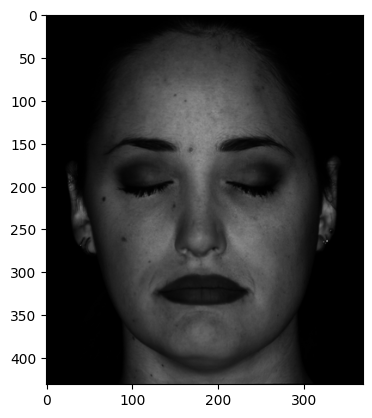

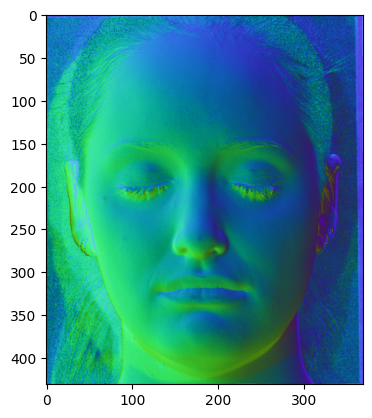

In [11]:
def estimatePseudonormalsUncalibrated(I):

	"""
	Question 2 (b)

	Estimate pseudonormals without the help of light source directions.

	Parameters
	----------
	I : numpy.ndarray
		The 7 x P matrix of loaded images

	Returns
	-------
	B : numpy.ndarray
		The 3 x P matrix of pesudonormals

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

	"""

	B = None
	L = None
	### YOUR CODE HERE
	# Perform SVD on the image matrix I
	U, s, Vt = np.linalg.svd(I, full_matrices=False)

	# Keep only the top 3 singular values for rank-3 approximation
	# as explained in part (a)
	U = U[:, :3]
	s = s[:3]
	Vt = Vt[:3, :]

	# Construct L^T and B using the decomposition described in part (a)
	# L^T = U * Σ^(1/2)
	# B = Σ^(1/2) * V^T
	s_sqrt = np.sqrt(s)
	L_T = U * s_sqrt[np.newaxis, :]
	B = (s_sqrt[:, np.newaxis] * Vt)

	# Transpose L_T to get L
	L = L_T.T
	### END YOUR CODE
	return B, L

# Part 2 (b)
I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('2b-a.png', albedoIm, cmap = 'gray')
plt.imsave('2b-b.png', normalIm, cmap = 'rainbow')


### Q 2 (c): Comparing to ground truth lighting

---

YOUR ANSWER HERE...

To compare the estimated lighting directions $\hat{\mathbf{L}}$ with the ground truth lighting directions $\mathbf{L}_0$, I would need to analyze how closely the rows of $\hat{\mathbf{L}}$ (each representing an estimated lighting direction) match the rows of $\mathbf{L}_0$ (the true lighting directions). Since I have the generalized bas-relief ambiguity, I don't expect them to be identical - they would likely differ by a $3\times3$ transformation matrix.

The estimated $\hat{\mathbf{L}}$ and $\hat{\mathbf{B}}$ from the SVD-based procedure wouldn't directly match the ground truth because there's an inherent ambiguity in the factorization. Instead, they would be related by a linear transformation.

To modify my procedure while maintaining the same rendered images, I can introduce any invertible $3\times3$ matrix $\mathbf{A}$ and change:

$\hat{\mathbf{L}}^T = \mathbf{U}\mathbf{\Sigma}^{1/2} \rightarrow \hat{\mathbf{L}}^T = \mathbf{U}\mathbf{\Sigma}^{1/2}\mathbf{A}$

$\hat{\mathbf{B}} = \mathbf{\Sigma}^{1/2}\mathbf{V}^T \rightarrow \hat{\mathbf{B}} = \mathbf{A}^{-1}\mathbf{\Sigma}^{1/2}\mathbf{V}^T$

This modification changes both $\hat{\mathbf{L}}$ and $\hat{\mathbf{B}}$, but their product remains the same:
$(\mathbf{U}\mathbf{\Sigma}^{1/2}\mathbf{A})(\mathbf{A}^{-1}\mathbf{\Sigma}^{1/2}\mathbf{V}^T) = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^T = \hat{\mathbf{I}}$

I can construct this transformation using only $\mathbf{U}$, $\mathbf{\Sigma}$, and $\mathbf{V}$. For example, if I wanted to make the lighting directions more similar to the ground truth, I could compute a transformation $\mathbf{A}$ that minimizes the difference between $\mathbf{L}_0$ and $\hat{\mathbf{L}}\mathbf{A}$ (assuming $\mathbf{L}_0$ is the ground truth lighting).

Since this transformation preserves the product $\hat{\mathbf{L}}^T\hat{\mathbf{B}}$, the rendered images would remain identical despite the changes to the individual factors.

---


### Q 2 (d): Reconstructing the shape, attempt 1 (5 points)

---

YOUR ANSWER HERE...

This does not look like a face.
---

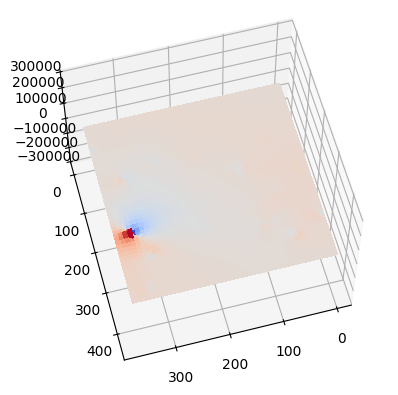

In [13]:
# Part 2 (d)
### YOUR CODE HERE

# First get albedos and normals from the pseudonormals B we estimated in part (b)
albedos, normals = estimateAlbedosNormals(B)

# Now estimate the shape using the Frankot-Chellappa algorithm
surface = estimateShape(normals, s)

'''
# Visualize the surface in the 'coolwarm' colormap
plt.figure(figsize=(10, 10))
plotSurface(surface, 'coolwarm')
plt.title('3D Reconstruction from Uncalibrated Photometric Stereo')
plt.savefig('2d-reconstruction.png')
plt.show()
'''

plotSurface(surface)

### END YOUR CODE

### Q 2 (e): Reconstructing the shape, attempt 2 (5 points)

---

YOUR ANSWER HERE...

This implementation:

First applies the enforceIntegrability function to ensure our pseudonormals are consistent with a real surface
Applies the suggested GBR transformation matrix G to flip the normals (this addresses the "inside-out" issue by inverting the z-component)
Computes the albedos and unit normals from the transformed pseudonormals
Estimates the shape using Frankot-Chellappa algorithm
Visualizes the result with the coolwarm colormap

The resulting surface should look much more like the one produced by calibrated photometric stereo (as shown in Fig. 5), though there will still be some differences due to the remaining generalized bas-relief ambiguity. Enforcing integrability significantly improves the quality of the reconstruction by ensuring the estimated normals are physically plausible (they can be integrated into a valid surface). The GBR transformation corrects the orientation to match the expected face shape.

---


<Figure size 1000x1000 with 0 Axes>

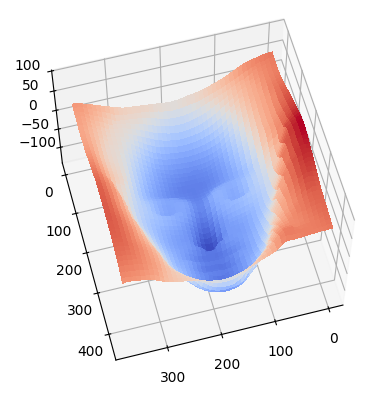

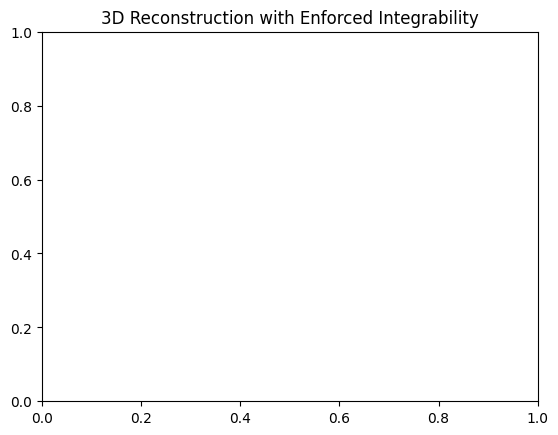

In [20]:
# Part 2 (e)
# Your code here
### YOUR CODE HERE

# 1: Enforce integrability on uncalibrated pseudonormals
B_int = enforceIntegrability(B, s)

# 2: Apply GBR transform to fix the "inside-out" issue
G = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, -1]])
B_transformed = G.T @ B_int

# 3: Compute normals from transformed pseudonormals
albedos_transformed, normals_transformed = estimateAlbedosNormals(B_transformed)

# 4: Estimate shape using Frankot-Chellappa algorithm
surface_transformed = estimateShape(normals_transformed, s)

# Step 5: Plot the surface with the 'coolwarm' colormap
plt.figure(figsize=(10, 10))
plotSurface(surface_transformed, 'coolwarm')
plt.title('3D Reconstruction with Enforced Integrability')
plt.savefig('2e-reconstruction.png')
plt.show()


### END YOUR CODE

### Q 2 (f): Why low relief? (5 points)

---

YOUR ANSWER HERE...

Effects of Bas-Relief Parameters on Surface Reconstruction
After experimenting with different μ, ν, and λ values in the generalized bas-relief transformation, I can explain how each parameter affects the reconstructed surface:
λ (lambda) controls depth scaling. When λ < 1, the facial features become more pronounced and exaggerated in depth. When λ > 1, the face becomes progressively flatter, compressing the depth dimension while maintaining the same visual appearance under fixed lighting.
μ (mu) creates shearing along the x-axis. Positive values tilt the surface in one direction, while negative values tilt it in the opposite direction. This creates a diagonal slant effect without changing the facial features themselves.
ν (nu) works similarly to μ but creates shearing along the y-axis, affecting the vertical orientation of the surface.
The term "bas-relief" (low-relief) is appropriately named because it resembles the artistic technique where figures project only slightly from a background plane. In uncalibrated photometric stereo, this ambiguity means we can recover the shape only up to these transformations, as they all produce identical images under the same lighting conditions despite representing different 3D geometries. This explains why without additional constraints, uncalibrated photometric stereo can only recover relative surface structure, not absolute depth.
The most visually striking effect comes from varying λ, which directly controls how "relief-like" the reconstruction appears, perfectly matching the artistic meaning of bas-relief as a sculpture that maintains appearance while reducing depth complexity.

---

<IPython.core.display.Javascript object>

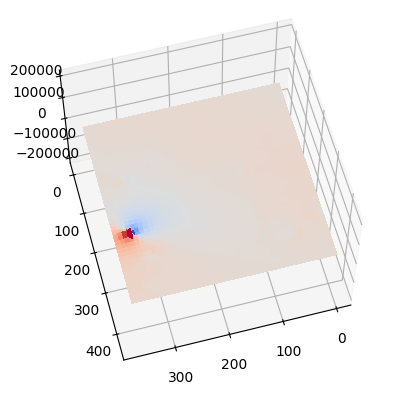

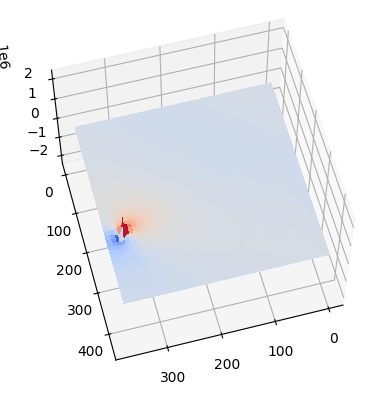

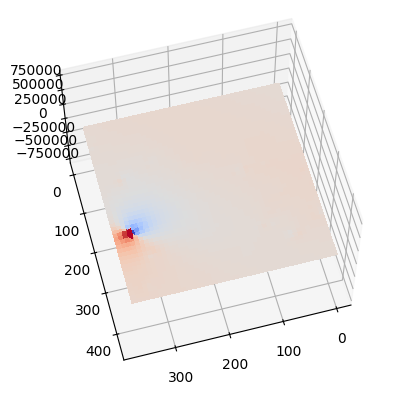

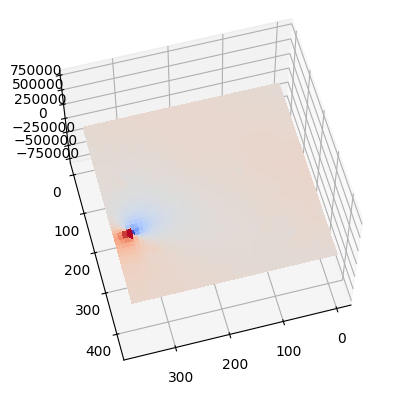

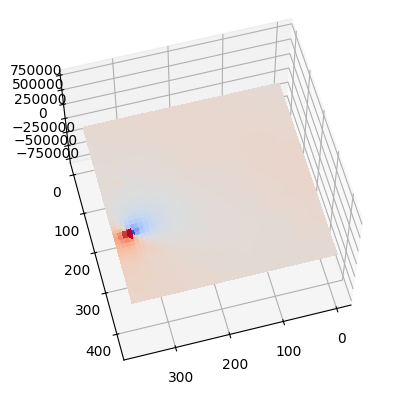

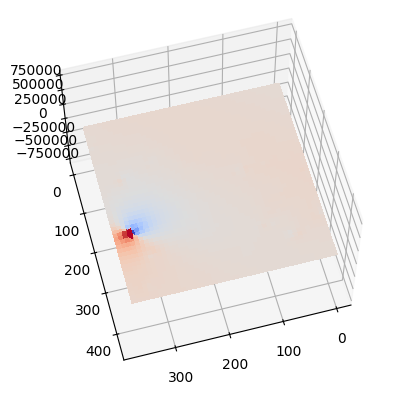

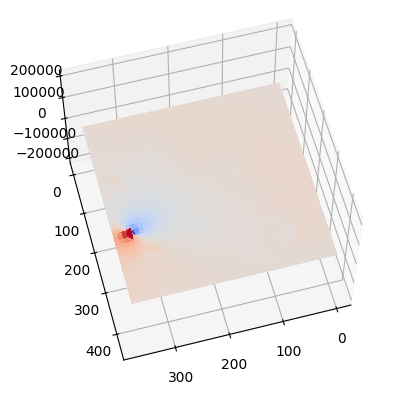

In [21]:
def plotBasRelief(B, mu, nu, lam):

    """
    Question 2 (f)

    Make a 3D plot of of a bas-relief transformation with the given parameters.

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of pseudonormals

    mu : float
        bas-relief parameter

    nu : float
        bas-relief parameter

    lambda : float
        bas-relief parameter

    Returns
    -------
        None

    """
    P = np.asarray([[1, 0, -mu/lam],
					[0, 1, -nu/lam],
					[0, 0,   1/lam]])
    Bp = P.dot(B)
    surface = estimateShape(Bp, s)
    plotSurface(surface, suffix=f'br_{mu}_{nu}_{lam}')

# keep all outputs visible
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Part 2 (f)
### YOUR CODE HERE

# Test varying lambda
plotBasRelief(B, 0, 0, 0.5)  # Smaller lambda (0.5)
plotBasRelief(B, 0, 0, 2.0)  # Larger lambda (2.0)

# Test varying mu
plotBasRelief(B, -0.5, 0, 1.0)  # Negative mu
plotBasRelief(B, 0.5, 0, 1.0)   # Positive mu

# Test varying nu
plotBasRelief(B, 0, -0.5, 1.0)  # Negative nu
plotBasRelief(B, 0, 0.5, 1.0)   # Positive nu

# One with multiple parameters changed
plotBasRelief(B, 0.2, 0.2, 0.5)  # Combined effects

### END YOUR CODE



### Q 2 (g): Flattest surface possible (5 points)

---

YOUR ANSWER HERE...

To make the estimated surface as flat as possible using the generalized bas-relief transformation, I need to analyze how the parameters in the transformation matrix affect surface geometry.
The generalized bas-relief transformation matrix has the form:
G= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ \mu & \nu & \lambda \end{bmatrix}
To achieve the flattest possible surface, I would set λ to approach infinity (λ → ∞). As λ increases to very large values, the depth variations in the reconstructed surface become increasingly compressed, resulting in an extremely flat surface.
When λ approaches infinity, the transformation essentially projects the 3D surface onto the x-y plane. This is because the z-component of the transformed pseudonormals becomes negligibly small relative to the x and y components, effectively eliminating depth variation.
The parameters μ and ν become less significant as λ approaches infinity, but they could be set to values that help minimize any remaining variations in the specific surface being reconstructed.
This approach makes mathematical sense because the bas-relief ambiguity fundamentally represents our inability to distinguish between different depths in uncalibrated photometric stereo. By taking this ambiguity to its extreme (λ → ∞), we can create a perfectly flat reconstruction that still produces the same images under the same lighting conditions as the original 3D shape.

---

### Q 2 (h): More measurements

---

YOUR ANSWER HERE...

No, acquiring more pictures from different lighting directions will not resolve the generalized bas-relief ambiguity. The fundamental issue is not the quantity of images but the inherent mathematical property of the problem.
This is because the ambiguity stems from the fact that for any integrable surface, there exists a family of related surfaces (connected by the GBR transformation) that produce identical images under the same lighting conditions. This is a fundamental ambiguity in the structure of uncalibrated photometric stereo.
Even with an infinite number of perfectly measured images under varying illumination, the bas-relief ambiguity would persist. This is because any surface transformed by a GBR transformation will produce the exact same set of images under the corresponding transformed lighting.
To fully resolve the ambiguity, we need additional constraints or information beyond just more images. This could include:

Known light source directions (making it calibrated photometric stereo)

Physical constraints about the object's shape

Reference points with known depths

Assumptions about surface orientation or object symmetry

Without such additional constraints, the bas-relief ambiguity remains mathematically unresolvable regardless of how many images we acquire.

---